In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() 
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

normal_class = 8

def filter_dataset(dataset, normal_class, train=True):
    if train:
        indices = [i for i, (_, label) in enumerate(dataset) if label == normal_class]
    else:
        indices = list(range(len(dataset)))
    return Subset(dataset, indices)

train_data = filter_dataset(train_dataset, normal_class, train=True)
test_data = filter_dataset(test_dataset, normal_class, train=False)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [4]:
from PIL import Image
from transformers import ViTModel, ViTImageProcessor
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_model.eval()

def extract_features(dataloader):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataloader):
        pil_images = [transforms.ToPILImage()(img) for img in images]
        inputs = image_processor(images=pil_images, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = vit_model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :] 
            all_features.append(cls_embeddings.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

if all(os.path.exists(f) for f in ["X_train.npy", "y_train.npy", "X_test.npy", "y_test.npy"]):
    print("Loading..")
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
else:
    print("Extracting..")
    X_train, y_train = extract_features(train_loader)
    X_test, y_test = extract_features(test_loader)
    
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_test.npy", X_test)
    np.save("y_test.npy", y_test)
    print("Saved.")

Loading..


In [5]:
center = np.mean(X_train, axis=0)

def deep_svdd_predict(X, center, threshold=None):
    distances = np.linalg.norm(X - center, axis=1)
    if threshold is None:
        threshold = np.percentile(distances, 95) 
    predictions = distances > threshold
    return predictions, distances, threshold

In [6]:
svm = OneClassSVM(gamma='auto').fit(X_train)
svm_preds = svm.predict(X_test)
svm_preds = np.where(svm_preds == -1, 1, 0)

iso = IsolationForest().fit(X_train)
iso_preds = iso.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)

pca = PCA(n_components=50).fit(X_train)
X_test_pca = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
reconstruction_error = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)
pca_threshold = np.percentile(reconstruction_error, 95)
pca_preds = reconstruction_error > pca_threshold

In [7]:
true_labels = (y_test != normal_class).astype(int)

def evaluate(preds, true):
    auc = roc_auc_score(true, preds)
    f1 = f1_score(true, preds)
    return auc, f1

print("Deep SVDD:", evaluate(deep_svdd_predict(X_test, center)[0], true_labels))
print("One-Class SVM:", evaluate(svm_preds, true_labels))
print("Isolation Forest:", evaluate(iso_preds, true_labels))
print("PCA:", evaluate(pca_preds, true_labels))

Deep SVDD: (0.5272222222222223, 0.10505263157894737)
One-Class SVM: (0.7372222222222222, 0.9713822894168467)
Isolation Forest: (0.5929444444444445, 0.33138942886235306)
PCA: (0.5277777777777778, 0.10526315789473684)


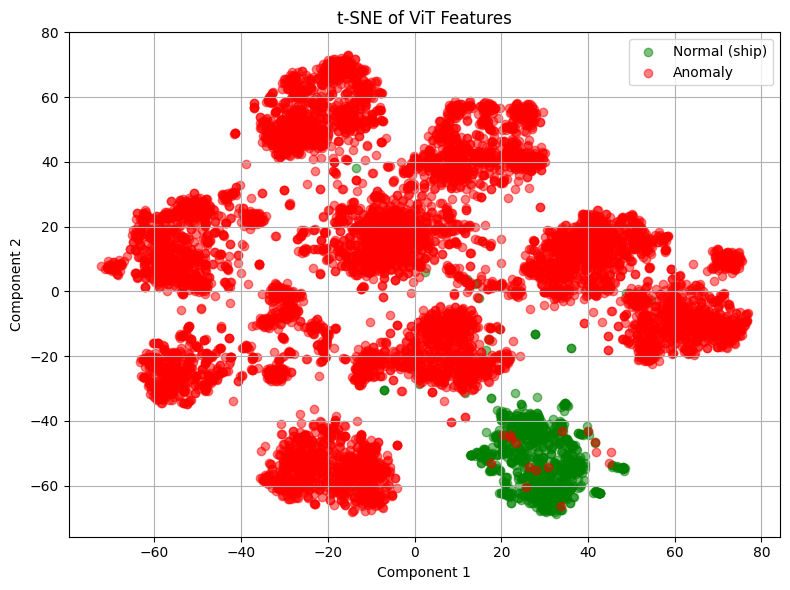

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[true_labels == 0, 0], X_tsne[true_labels == 0, 1], c='green', label='Normal (ship)', alpha=0.5)
plt.scatter(X_tsne[true_labels == 1, 0], X_tsne[true_labels == 1, 1], c='red', label='Anomaly', alpha=0.5)
plt.legend()
plt.title("t-SNE of ViT Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal Threshold (SVM): 12.4158
One-Class SVM (optimal threshold): (0.8866111111111111, 0.9652178815040307)


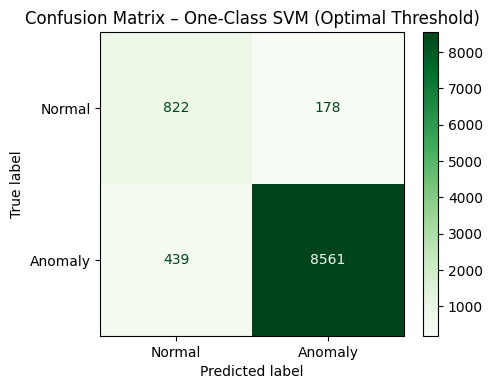

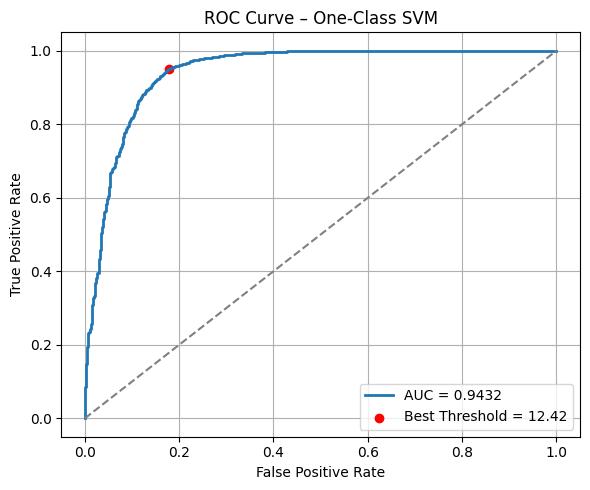

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

svm_scores = svm.decision_function(X_test)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(true_labels, -svm_scores)  
auc_svm = roc_auc_score(true_labels, -svm_scores)

j_scores_svm = tpr_svm - fpr_svm
best_idx_svm = np.argmax(j_scores_svm)
best_threshold_svm = thresholds_svm[best_idx_svm]
print(f"Optimal Threshold (SVM): {best_threshold_svm:.4f}")

svm_preds_opt = -svm_scores > best_threshold_svm

print("One-Class SVM (optimal threshold):", evaluate(svm_preds_opt, true_labels))
cm_svm = confusion_matrix(true_labels, svm_preds_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Greens", values_format='d')
plt.title("Confusion Matrix – One-Class SVM (Optimal Threshold)")
plt.tight_layout()
plt.savefig("confusion_matrix_svm_optimal.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {auc_svm:.4f}", linewidth=2)
plt.scatter(fpr_svm[best_idx_svm], tpr_svm[best_idx_svm], c='red', label=f"Best Threshold = {best_threshold_svm:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – One-Class SVM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_svm.png", dpi=300)
plt.show()

Optimal Threshold (IF): -0.0414
Isolation Forest (optimal threshold): (0.8692777777777778, 0.9496197175044319)


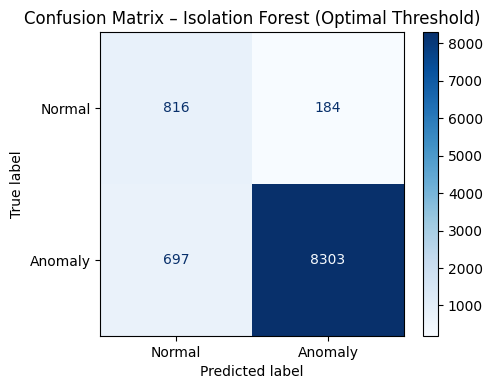

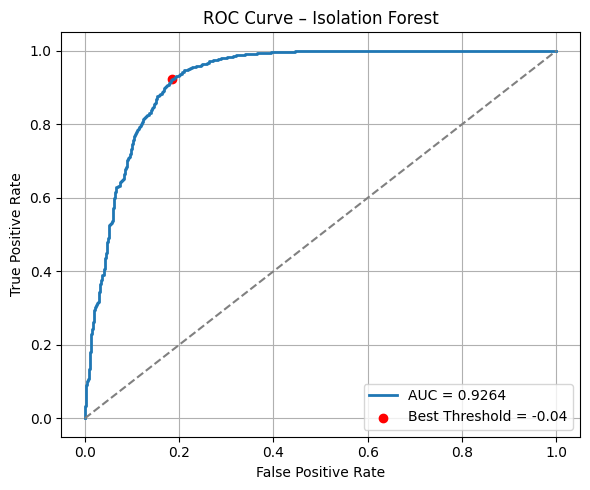

In [10]:
iso_scores = iso.decision_function(X_test)

fpr_iso, tpr_iso, thresholds_iso = roc_curve(true_labels, -iso_scores) 
auc_iso = roc_auc_score(true_labels, -iso_scores)

j_scores_iso = tpr_iso - fpr_iso
best_idx_iso = np.argmax(j_scores_iso)
best_threshold_iso = thresholds_iso[best_idx_iso]
print(f"Optimal Threshold (IF): {best_threshold_iso:.4f}")

iso_preds_opt = -iso_scores > best_threshold_iso

print("Isolation Forest (optimal threshold):", evaluate(iso_preds_opt, true_labels))

cm_iso = confusion_matrix(true_labels, iso_preds_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_iso, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix – Isolation Forest (Optimal Threshold)")
plt.tight_layout()
plt.savefig("confusion_matrix_if_optimal.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(fpr_iso, tpr_iso, label=f"AUC = {auc_iso:.4f}", linewidth=2)
plt.scatter(fpr_iso[best_idx_iso], tpr_iso[best_idx_iso], c='red', label=f"Best Threshold = {best_threshold_iso:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Isolation Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_if.png", dpi=300)
plt.show()

Optimal Threshold (PCA): 0.0149
PCA (optimal threshold): (0.9454444444444444, 0.9803459119496856)


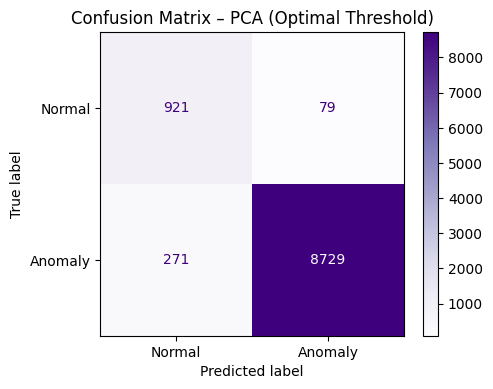

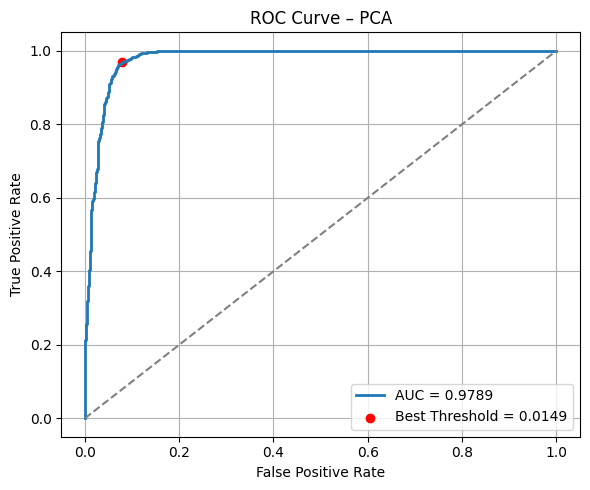

In [11]:

reconstruction_error = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)

fpr_pca, tpr_pca, thresholds_pca = roc_curve(true_labels, reconstruction_error)
auc_pca = roc_auc_score(true_labels, reconstruction_error)

j_scores_pca = tpr_pca - fpr_pca
best_idx_pca = np.argmax(j_scores_pca)
best_threshold_pca = thresholds_pca[best_idx_pca]
print(f"Optimal Threshold (PCA): {best_threshold_pca:.4f}")

pca_preds_opt = reconstruction_error > best_threshold_pca


print("PCA (optimal threshold):", evaluate(pca_preds_opt, true_labels))

cm_pca = confusion_matrix(true_labels, pca_preds_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Purples", values_format='d')
plt.title("Confusion Matrix – PCA (Optimal Threshold)")
plt.tight_layout()
plt.savefig("confusion_matrix_pca_optimal.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(fpr_pca, tpr_pca, label=f"AUC = {auc_pca:.4f}", linewidth=2)
plt.scatter(fpr_pca[best_idx_pca], tpr_pca[best_idx_pca], c='red', label=f"Best Threshold = {best_threshold_pca:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – PCA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_pca.png", dpi=300)
plt.show()

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SVDDNet(nn.Module):
    def __init__(self, input_dim=768, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, rep_dim)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SVDDNet(input_dim=768, rep_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
def svdd_loss(outputs, center):
    dists = torch.sum((outputs - center) ** 2, dim=1)
    return torch.mean(dists)

In [15]:
X_tensor = torch.tensor(X_train, dtype=torch.float32)

model.eval()
with torch.no_grad():
    reps = []
    batch_size = 128
    for i in range(0, len(X_tensor), batch_size):
        x_batch = X_tensor[i:i+batch_size].to(device)
        rep = model(x_batch)
        reps.append(rep)
    reps = torch.cat(reps)
    center = reps.mean(dim=0)

In [16]:
epochs = 50
train_dl = torch.utils.data.DataLoader(X_tensor, batch_size=128, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x in train_dl:
        x = x.to(device)
        outputs = model(x)
        loss = svdd_loss(outputs, center)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_dl):.4f}")

Epoch 1/50, Loss: 0.0536
Epoch 2/50, Loss: 0.0209
Epoch 3/50, Loss: 0.0129
Epoch 4/50, Loss: 0.0090
Epoch 5/50, Loss: 0.0066
Epoch 6/50, Loss: 0.0051
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0027
Epoch 10/50, Loss: 0.0023
Epoch 11/50, Loss: 0.0020
Epoch 12/50, Loss: 0.0017
Epoch 13/50, Loss: 0.0015
Epoch 14/50, Loss: 0.0013
Epoch 15/50, Loss: 0.0012
Epoch 16/50, Loss: 0.0010
Epoch 17/50, Loss: 0.0009
Epoch 18/50, Loss: 0.0008
Epoch 19/50, Loss: 0.0008
Epoch 20/50, Loss: 0.0007
Epoch 21/50, Loss: 0.0006
Epoch 22/50, Loss: 0.0006
Epoch 23/50, Loss: 0.0005
Epoch 24/50, Loss: 0.0005
Epoch 25/50, Loss: 0.0005
Epoch 26/50, Loss: 0.0004
Epoch 27/50, Loss: 0.0004
Epoch 28/50, Loss: 0.0004
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0003
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0003
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0003
Epoch 35/50, Loss: 0.0002
Epoch 36/50, Loss: 0.0002
Epoch 37/50, Loss: 0.0002
Epoch 38/50, Loss: 0.0002
Epoch 39/50, Loss: 0.


Best threshold: 0.0008
Learned Deep SVDD: (AUC: 0.9888, F1: 0.9813)


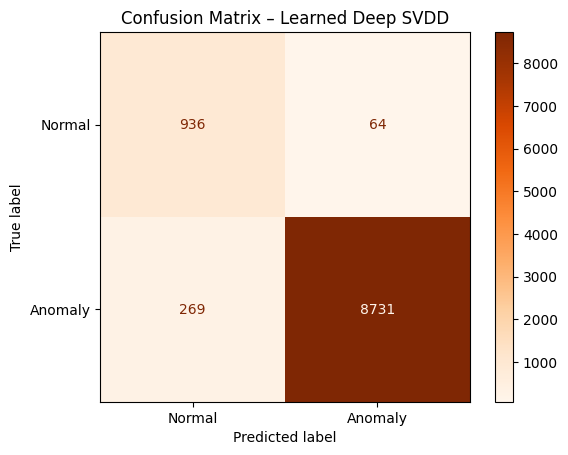

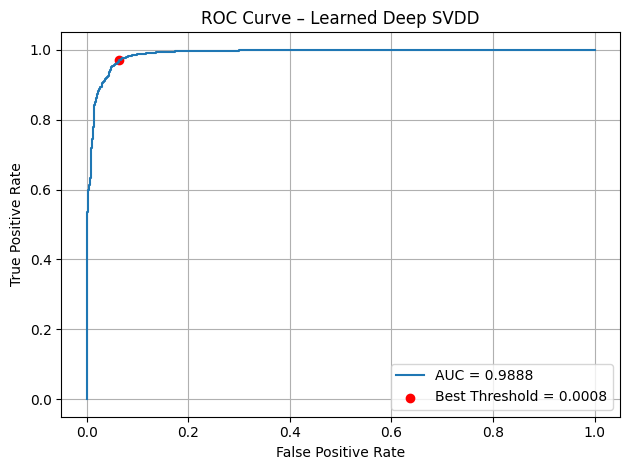

In [17]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_dists = torch.sum((test_outputs - center) ** 2, dim=1).cpu().numpy()

fpr, tpr, thresholds = roc_curve(true_labels, test_dists)
optimal_idx = np.argmax(tpr - fpr)
best_thresh = thresholds[optimal_idx]

preds = (test_dists > best_thresh).astype(int)

auc = roc_auc_score(true_labels, test_dists)
f1 = f1_score(true_labels, preds)
print(f"\nBest threshold: {best_thresh:.4f}")
print(f"Learned Deep SVDD: (AUC: {auc:.4f}, F1: {f1:.4f})")

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix – Learned Deep SVDD")
plt.show()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', label=f"Best Threshold = {best_thresh:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Learned Deep SVDD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()